# Midterm 

The objective of the midterm is to make you think like a data scientist.

Imagine you have been transported to 1854 London, where there is an outbreak of cholera.
The current scientific knowledge on germ theory is rudimentary, and mostly incorrect.
There is no notion of epidemiology.

You have your laptop. Can you demonstrate the solution that John Snow was able to devise?


# 1854 Broad Street cholera outbreak
---

https://en.wikipedia.org/wiki/John_Snow

>John Snow (15 March 1813 – 16 June 1858) was an English physician and a leader in the development of anaesthesia and medical hygiene. He is considered one of the founders of modern epidemiology, in part because of his work in tracing the source of a cholera outbreak in Soho, London, in 1854, which he curtailed by removing the handle of a water pump. Snow's findings inspired the adoption of anaesthesia as well as fundamental changes in the water and waste systems of London, which led to similar changes in other cities, and a significant improvement in general public health around the world.

>Snow used a dot map to illustrate the cluster of cholera cases around the pump. He also used statistics to illustrate the connection between the quality of the water source and cholera cases. He showed that homes supplied by the Southwark and Vauxhall Waterworks Company, which was taking water from sewage-polluted sections of the Thames, had a cholera rate fourteen times that of those supplied by Lambeth Waterworks Company, which obtained water from the upriver, cleaner Seething Wells.

>Snow's study was a major event in the history of public health and geography.
**It is regarded as the founding event of the science of epidemiology.**

---

## We will attempt to retrace the argument made by Snow, using tools we have learned 

## The data is as follows:

+ Confirmed cholera deaths
+ Water pump location (black square)


## Q1. Is the disease waterborne?

+ Show that the probability of cholera deaths are strongly spatially associated with location of water pumps

## Q2. Locate the pump that is most likely the source of the disease, with estimated probability 
    
+ Show that an unique pump is central to the estimated distribution of deaths
+ Hint: Use different ensemble regressors to estimate the distrbution of deaths on a fine grid, trained with the data that is available
+ How do you know which regressor is most "believable"?



In [2]:
import pandas as pd
import pylab as plt
import matplotlib.colors as colors
import geopandas as gd
import contextily as cx
import warnings
import matplotlib.colors as colors

warnings.filterwarnings('ignore')
%matplotlib inline

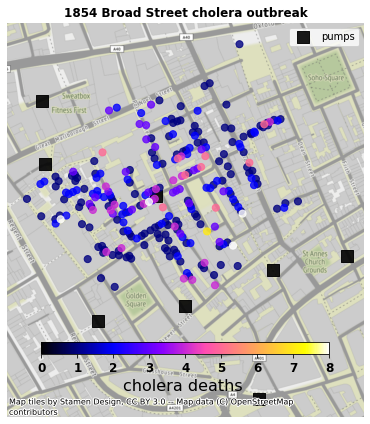

In [5]:
fig = plt.figure(figsize=[8,6])
ax=plt.gca()
cax = fig.add_axes([0.25,0.17,.5,.03])
plt.sca(ax)
df = gd.read_file('../datasets/SnowGIS_SHP/Cholera_Deaths.shp').to_crs('epsg:3857').sort_values('Count')

pf = gd.read_file('../datasets/SnowGIS_SHP/Pumps.shp').to_crs('epsg:3857')
pf.plot(ax=ax,color='k',markersize=130,marker='s',alpha=.9,label='pumps')
df.plot(column='Count',ax=ax,markersize=50,cax=cax,cmap='gnuplot2',norm=colors.Normalize(vmin=0.,vmax=8.),
        legend=True,legend_kwds={'orientation': "horizontal"},alpha=.8)
cx.add_basemap(ax, crs=df.crs.to_string())
ax.axis('off');
ax.legend()
ax.set_title('1854 Broad Street cholera outbreak',fontweight='bold')
plt.tight_layout()
plt.setp(cax.get_xticklabels(), fontsize=12,fontweight='bold')
cax.set_xlabel('cholera deaths ',fontsize=16);
#plt.savefig('1854.png',dpi=600,bbox_inches='tight',transparent=True)

In [6]:
# df is a geopandas dataframe. Note the geometry column
df

,Id,Count,geometry
249,0,1,POINT (-15335.608 6712339.425)
96,0,1,POINT (-15117.190 6712370.749)
187,0,1,POINT (-14993.571 6712804.021)
186,0,1,POINT (-15012.503 6712806.521)
99,0,1,POINT (-15044.203 6712374.145)
...,...,...,...
111,0,7,POINT (-15064.719 6712502.115)
117,0,8,POINT (-14960.620 6712554.121)
39,0,8,POINT (-15494.201 6712537.692)
113,0,8,POINT (-14988.576 6712460.393)


In [7]:
# we can convert the geometry column to XY values (lat/long pairs) as follows
df1=df.to_crs(epsg='4326')
X=df1.geometry.x
Y=df1.geometry.y

In [8]:
# now we have XY pairs added to the geopandas dataframe
df1=df1.assign(X=X,Y=Y)
df1.head()

,Id,Count,geometry,X,Y
249,0,1,POINT (-0.13776 51.51186),-0.137762,51.511856
96,0,1,POINT (-0.13580 51.51203),-0.135800,51.512031
187,0,1,POINT (-0.13469 51.51445),-0.134690,51.514453
186,0,1,POINT (-0.13486 51.51447),-0.134860,51.514467
99,0,1,POINT (-0.13514 51.51205),-0.135144,51.512050


In [9]:
# we can extract the data to be used in sklearn functions as follows
X_=df1[['X','Y']].values
y_=df1.Count.values

In [10]:
y_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,
        4,  4,  4,  4,  4